# Brain Cancer MRI Images Classification

Cancer is the second leading cause of death after cardiovascular diseases. Out of all types of cancer, brain cancer has the lowest survival rate. Brain tumors can have different types depending on several factors such as the shape, texture, and location of the tumor (e.g., Acoustic Neuroma, Meningioma, Pituitary, Glioma, CNS Lymphoma . . . etc). In clinical practice, the incident rates of Glioma, Meningioma, and Pituitary tumors are approximately 45%, 15%, and 15%, respectively, among all brain tumors. Proper diagnosis of the tumor type enables the doctor to make the correct treatment choice and help save the patient’s life.


Currently, anomaly detection through MRI is manual mostly and clinicians have to spend a lot of time to detect and segment the tumor for treatment and surgical purpose. This manual technique is also prone to errors and can compromise life. Also, diversity of Tumor types, makes the detection more difficult due to the complex structure of the brain. In order to resolve these issues, studies have started to focus on various machine learning and Deep Learning techniques for computer-based tumor detection and segmentation.


 [This paper](https://www.sciencedirect.com/science/article/abs/pii/S0895611121000896?via%3Dihub) reviews different papers that tried to do the task of brain cancer MRI image classification. In this homework, we will implement and compare some of these methods.

First, import all the libraries you may need here:

In [54]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import h5py
from PIL import Image
from google.colab import drive
import os
import keras
import tensorflow as tf
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import Model, layers
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import Dense, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout

## 1. Load Data (5 pt)

We have a dataset of 3064 T1-weighted contrast-enhanced MRI images of 3 brain tumor types (Meningiomas, Gliomas, and Pituitary tumors). You are supposed to download and unzip the [data](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5).

We suggest loading all of the data in one folder in google drive.

In [ ]:
from google.colab import files

!wget "https://figshare.com/ndownloader/articles/1512427/versions/5"
!unzip 5
!unzip brainTumorDataPublic_1-766.zip
!unzip brainTumorDataPublic_1533-2298.zip
!unzip brainTumorDataPublic_767-1532.zip
!unzip brainTumorDataPublic_2299-3064.zip

--2022-12-12 15:07:37--  https://figshare.com/ndownloader/articles/1512427/versions/5
Resolving figshare.com (figshare.com)... 52.31.140.124, 52.51.22.31, 2a05:d018:1f4:d000:ee56:1548:7c1d:d56b, ...
Connecting to figshare.com (figshare.com)|52.31.140.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘5’

5                   100%[===================>] 838.76M  29.8MB/s    in 29s     

2022-12-12 15:08:07 (28.7 MB/s) - ‘5’ saved [879501695/879501695]

Archive:  5
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              
Archive:  brainTumorDataPublic_1-766.zip
  inflating: 1.mat                   
  inflating: 10.mat                  
  inflating: 100.mat                 
  inflating: 101.mat              

## 2. Visualize some Images (7 pt)

In this part, we want to show 2 random MRI images from each category in the dataset. As we have 3 types of tumors, we should have 6 images in the output.

In this dataset, the images are in matlab format and each image is stored as a struct that includes tumorMask, tumorBorder, image, PID (PatientID), label. The h5py library is used to read the photos in the code section. Using this library, we read the dataset images that are in mat format.

 Images are labeled this way in .mat files:

Label 1: meningioma

Label 2: glioma

Label 3: pituitary

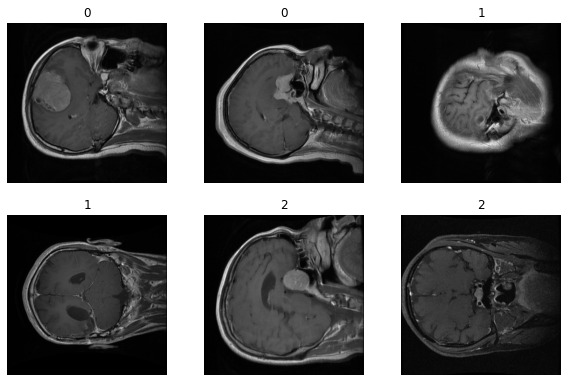

In [6]:
import random
# keys = ['PID', 'image', 'label', 'tumorBorder', 'tumorMask']

images = [[], [], []]
labels = [[], [], []]
for i in range(1, 3064):
  f = h5py.File("{i}.mat".format(i=i), 'a')
  label = int(f['/cjdata/label'][0][0])
  image = np.array(f['/cjdata/image'])
  images[label-1].append(image)
  labels[label-1].append(label)

ind1, ind2 = random.sample(range(len(images[0])), 2)
ind3, ind4 = random.sample(range(len(images[1])), 2)
ind5, ind6 = random.sample(range(len(images[2])), 2)
sample_labels = [0, 0, 1, 1, 2, 2]
sample_indexes = [ind1, ind2, ind3, ind4, ind5, ind6]

plt.figure(figsize=(10, 10))
for i, index in enumerate(sample_indexes):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[sample_labels[i]][index], cmap='gray')
  plt.title(sample_labels[i])
  plt.axis("off")

## Split images to validation and train (10 pt)

Now, we want to save images in 3 different folders. Each folder should contain MRI images of one tumor type.

Then you should split data to train and validation. 80% of the data should be train and the rest should be validation.


In [ ]:
from sklearn.model_selection import train_test_split

train_dir = '/content/train/'
val_dir = '/content/val/'

!mkdir train/
!mkdir train/meningioma
!mkdir train/glioma
!mkdir train/pituitary
!mkdir val/
!mkdir val/meningioma
!mkdir val/glioma
!mkdir val/pituitary

X_train, X_test, y_train, y_test = train_test_split(np.array(images[0]), np.array(labels[0]), test_size=0.2, random_state=42)
[cv2.imwrite("train/meningioma/{i}.jpg".format(i=i), img) for i, img in enumerate(X_train)]
[cv2.imwrite("val/meningioma/{i}.jpg".format(i=i), img) for i, img in enumerate(X_test)]

X_train, X_test, y_train, y_test = train_test_split(np.array(images[1]), np.array(labels[1]), test_size=0.2, random_state=42)
[cv2.imwrite("train/glioma/{i}.jpg".format(i=i), img) for i, img in enumerate(X_train)]
[cv2.imwrite("val/glioma/{i}.jpg".format(i=i), img) for i, img in enumerate(X_test)]

X_train, X_test, y_train, y_test = train_test_split(np.array(images[2]), np.array(labels[2]), test_size=0.2, random_state=42)
[cv2.imwrite("train/pituitary/{i}.jpg".format(i=i), img) for i, img in enumerate(X_train)]
[cv2.imwrite("val/pituitary/{i}.jpg".format(i=i), img) for i, img in enumerate(X_test)]

### Data Preprocessing (15 pt)

Medical images datasets are smaller in size than the datasets available in other domains due to their limitations. One way to overcome the problem of lack of sufficient amount of training data is data augmentation.

There are many type of manipulations that we can use for this target. Here are a list of some augmentation techniques that you can use in this task:

Horizontal and vertical flips

Rotation

Zooming

Shifting

Shearing

Brightness

ZCA whitening

In [12]:
train_dir = '/content/train'
val_dir =  '/content/val'

train_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =30,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(224,224))
val_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =30,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(224,224))

Found 2449 images belonging to 3 classes.
Found 614 images belonging to 3 classes.


## Implementing 3 Different Classification Models

Now we want to design models for MRI image classification. Models that we want to use are these:

1- ResNet50

2- AlexNet

3- Multi-layer perceptron

### ResNet Model Design, image level (20pt)

Now it's time to create the model. Here we use Residual Network architecture composed of 50 layers for our model. Set the optimizer to 'Adam' and learning rate to '0.0003' for 200 epoches. You can change settings like LR untill getting better performance.


In this task we consentrate on the content of [this paper](https://doi.org/10.1016/j.artmed.2019.101779).

In [ ]:
model= ResNet50(include_top=False,
                   input_shape=(224, 224, 3))

ResNet_model = keras.models.Sequential()
ResNet_model.add(model)
ResNet_model.add(keras.layers.Flatten())
ResNet_model.add(keras.layers.Dense(512, activation='relu'))
ResNet_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
ResNet_model.summary()

In [106]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

### Train the ResNet50 model (10pt)

Now train the model and save accuracy, precision, recall, and f1-score every epoch.


In [ ]:
ResNet_model.compile(optimizer=Adam(0.0003),loss='categorical_crossentropy',metrics=['accuracy', precision, recall, f1])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=0, factor=0.5, min_lr=0.000000001)
history = ResNet_model.fit(traindata, epochs=200, validation_data=valdata, callbacks=[learning_rate_reduction])

###Loss and accuracy diagrams for ResNet50 (10 pt)

Now plot results for accuracy of train and validation during epoches.

In another plot show loss for train and validation during epoches.

Explain the results.

In [ ]:
epochs = [i for i in range(200)]
fig , ax = plt.subplots(1, 2)
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , history.history['accuracy'] , 'b-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , history.history['loss'] , 'b-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

###ResNet Model, Patient level (30 pt)


Here we want to repeat ResNet model in a different way. You should do all the steps again with a difference in spliting the data. In patient level you should pay attention that all the images from a patient should be either in train or validation.

So, do the spliting part of data with considering this point and then do all the steps again (design the model, train the model, plot accuracy and loss diagrams).


How different are the results?

Which method do yo think is better? Which results are more reliable? Image level method or patient level method?

In [92]:
images = {}

for i in range(1, 3064):
  f = h5py.File("{i}.mat".format(i=i), 'a')
  pid = f['/cjdata/PID'][()]
  pid = ''.join([str(pid[i][0]) for i in range(pid.shape[0])])
  label = int(f['/cjdata/label'][0][0])
  image = np.array(f['/cjdata/image'])
  if not pid in images.keys():
    images[pid] = []
  image = cv2.resize(image, (224, 224))
  image = cv2.merge((image, image, image))
  images[pid].append((image, label-1))

In [93]:
import random

keys = list(images.keys())
values = list(images.values())

temp = list(zip(keys, values))
np.random.shuffle(temp)
keys, values = zip(*temp)

lens = [len(images[key]) for key in keys]
lens_cumsum = (np.cumsum(lens)/3063).tolist()
lens_cumsum

[0.0019588638589618022,
 0.002285341168788769,
 0.008161932745674175,
 0.009467841984982043,
 0.015670910871694418,
 0.019262161279791055,
 0.022526934378060724,
 0.025791707476330396,
 0.031341821743388835,
 0.03232125367286973,
 0.040156709108716944,
 0.04733920992491022,
 0.05452171074110349,
 0.05582761998041136,
 0.06072477962781587,
 0.06562193927522038,
 0.07280444009141365,
 0.07411034933072151,
 0.07900750897812601,
 0.0832517140058766,
 0.08651648710414626,
 0.09369898792033954,
 0.09859614756774404,
 0.10022853411687888,
 0.10120796604635977,
 0.10349330721514854,
 0.10936989879203396,
 0.11002285341168788,
 0.11426705843943846,
 0.11557296767874632,
 0.1158994449885733,
 0.11753183153770813,
 0.12014365001632386,
 0.12634671890303623,
 0.13418217433888344,
 0.13940581129611493,
 0.14332353901403852,
 0.14365001632386548,
 0.1495266079007509,
 0.15279138099902057,
 0.15899444988573294,
 0.1622592229840026,
 0.16976820111002286,
 0.17042115572967678,
 0.17270649689846557,
 0.

In [94]:
lens_cumsum.index(0.8031341821743389)

187

In [95]:
import itertools

unzipped = list(zip(*list(itertools.chain.from_iterable(list(values)[:187]))))
X_train, y_train = np.array(unzipped[0]), np.array(unzipped[1])

unzipped = list(zip(*list(itertools.chain.from_iterable(list(values)[187:]))))
X_val, y_val = np.array(unzipped[0]), np.array(unzipped[1])

In [82]:
y_train = tf.keras.utils.to_categorical(y_train, 3)
y_val = tf.keras.utils.to_categorical(y_val, 3)

In [102]:
train_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =30,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
traindata = train_data.flow(X_train, y_train)

val_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =30,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
valdata = val_data.flow(X_val, y_val)

In [104]:
model= ResNet50(include_top=False,
                   input_shape=(224, 224, 3))

ResNet_model = keras.models.Sequential()
ResNet_model.add(model)
ResNet_model.add(keras.layers.Flatten())
ResNet_model.add(keras.layers.Dense(512, activation='relu'))
ResNet_model.add(keras.layers.Dense(1, activation='sigmoid'))

ResNet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               51380736  
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 74,968,961
Trainable params: 74,915,841
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
ResNet_model.compile(optimizer=Adam(0.0003),loss='categorical_crossentropy',metrics=['accuracy', precision, recall, f1])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=0, factor=0.5, min_lr=0.000000001)
history = ResNet_model.fit(traindata, epochs=200, validation_data=valdata, callbacks=[learning_rate_reduction])

## 1. AlexNet Model Design (20 pt)

Now we want to test another model. We will use AlexNet here.

Run it for 100 epoches. You can change settings to get better performance.

set optimizer = 'Adam' and loss = 'categorical_crossentropy'.



In [110]:
train_dir = '/content/train'
val_dir =  '/content/val'

train_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =30,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
traindata = train_data.flow_from_directory(directory=train_dir,target_size=(224,224))
val_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =30,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(224,224))

Found 2449 images belonging to 3 classes.
Found 614 images belonging to 3 classes.


In [111]:
def AlexnetModel(input_shape,num_classes):
  model = Sequential()
  model.add(Conv2D(filters=96,kernel_size=(3,3),strides=(4,4),input_shape=input_shape, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(256,(5,5),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
  model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes,activation='softmax'))
  return model

AlexNet_model = AlexnetModel((224, 224, 3), 3)

In [109]:
AlexNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 96)        2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 384)      

### Train the AlexNet model (10pt)

Now train the model and save accuracy, precision, recall, and f1-score every epoch.

In [ ]:
AlexNet_model.compile(optimizer=Adam(0.001),loss='categorical_crossentropy',metrics=['accuracy', precision, recall, f1])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=0, factor=0.5, min_lr=0.000000001)
history = AlexNet_model.fit(traindata, epochs=100, validation_data=valdata, callbacks=[learning_rate_reduction])

###Loss and accuracy diagrams for AlexNet (10 pt)

Now plot results for accuracy of train and validation during epoches.

In another plot show loss for train and validation during epoches.

Explain the results.

In [ ]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1, 2)
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , history.history['accuracy'] , 'b-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , history.history['loss'] , 'b-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

##Design the Multi-Layer Perceptron model (20 pt)

We want to implement a Multi layer perceptron deep network to classify our dataset too.

Do the steps as you did in other models.

In [ ]:
image_size = 128
batch_size = 32

train_dir = '/content/train'
val_dir = '/content/val'

train_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =30,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
traindata = train_data.flow_from_directory(directory=train_dir, target_size=(image_size,image_size))

val_data = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =30,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = True)
valdata = val_data.flow_from_directory(directory=val_dir, target_size=(image_size,image_size))

In [ ]:
MLP_model = Sequential()
MLP_model.add(Flatten(input_shape = (image_size, image_size, 3)))
MLP_model.add(Dense(2048, activation = 'relu'))
MLP_model.add(Dropout(rate = 0.2))
MLP_model.add(Dense(1024, activation = 'relu'))
MLP_model.add(Dropout(rate = 0.2))
MLP_model.add(Dense(512, activation = 'relu'))
MLP_model.add(Dropout(rate = 0.2))
MLP_model.add(Dense(4, activation = 'softmax'))

In [ ]:
MLP_model.summary()

###Train the model (10pt)

In [ ]:
MLP_model.compile(optimizer=Adam(0.001),loss='categorical_crossentropy',metrics=['accuracy', precision, recall, f1])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=0, factor=0.5, min_lr=0.000000001)
history = MLP_model.fit(traindata, epochs=100, validation_data=valdata, callbacks=[learning_rate_reduction])

###Loss and accuracy diagrams for multi-layer perceptron (10 pt)


In [ ]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1, 2)
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , history.history['accuracy'] , 'b-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , history.history['loss'] , 'b-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

####Now answer these questions:

1- How close are your answers to those in the paper?

2- Why do you think they aren't close if they aren't?

3- What suggestions do you have for improving any of these methods?

4- Compare the results from these 3 models. How would you rate each method in terms of its effectiveness?

5- Can we trust our answer for any MRI image of a patient? Answer the question in detail.